Carga y configuración de la señal EMG del brazo en reposo

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Cargar datos desde el archivo txt
file_path = "../../Documentacion/Laboratorios/Lab3_EMG/Brazo_reposo.txt"  # Ruta del archivo
array = np.genfromtxt(file_path, skip_header=2)
canalA4 = array[:,8]

# Configuración de la señal
fs = 1000  # Frecuencia de muestreo en Hz
num_samples = canalA4.shape[0]  # Número de muestras
time = np.arange(len(canalA4)) / fs # Generar el vector de tiempo en segundos
VCC = 3.3  # Voltaje de operación
n = 10  # Número de bits del canal
EMG_V = (((canalA4 / pow(2, n)) - 0.5) * VCC) / num_samples
EMG_uV = EMG_V * pow(10, 6)

Comparación de filtros según la bibliografía
Filtrado 1: Butterworth pasabanda (5-500 Hz)  - Filtro Notch (60 Hz) - N°orden = 2
Filtrado 2: Butterworth pasabanda (20-500 Hz) - Filtro Notch (50 Hz) - N°orden = 2
Filtrado 3: Butterworth pasabanda (10-500 Hz) - Sin filtro Notch     - N°orden = 2
Filtrado 4: Butterworth pasabanda (20-350 Hz) - Filtro Notch (50 Hz) - N°orden = 2
Filtrado 5: Butterworth pasabanda (6-500 Hz)  - Sin filtro Notch     - N°orden = 2

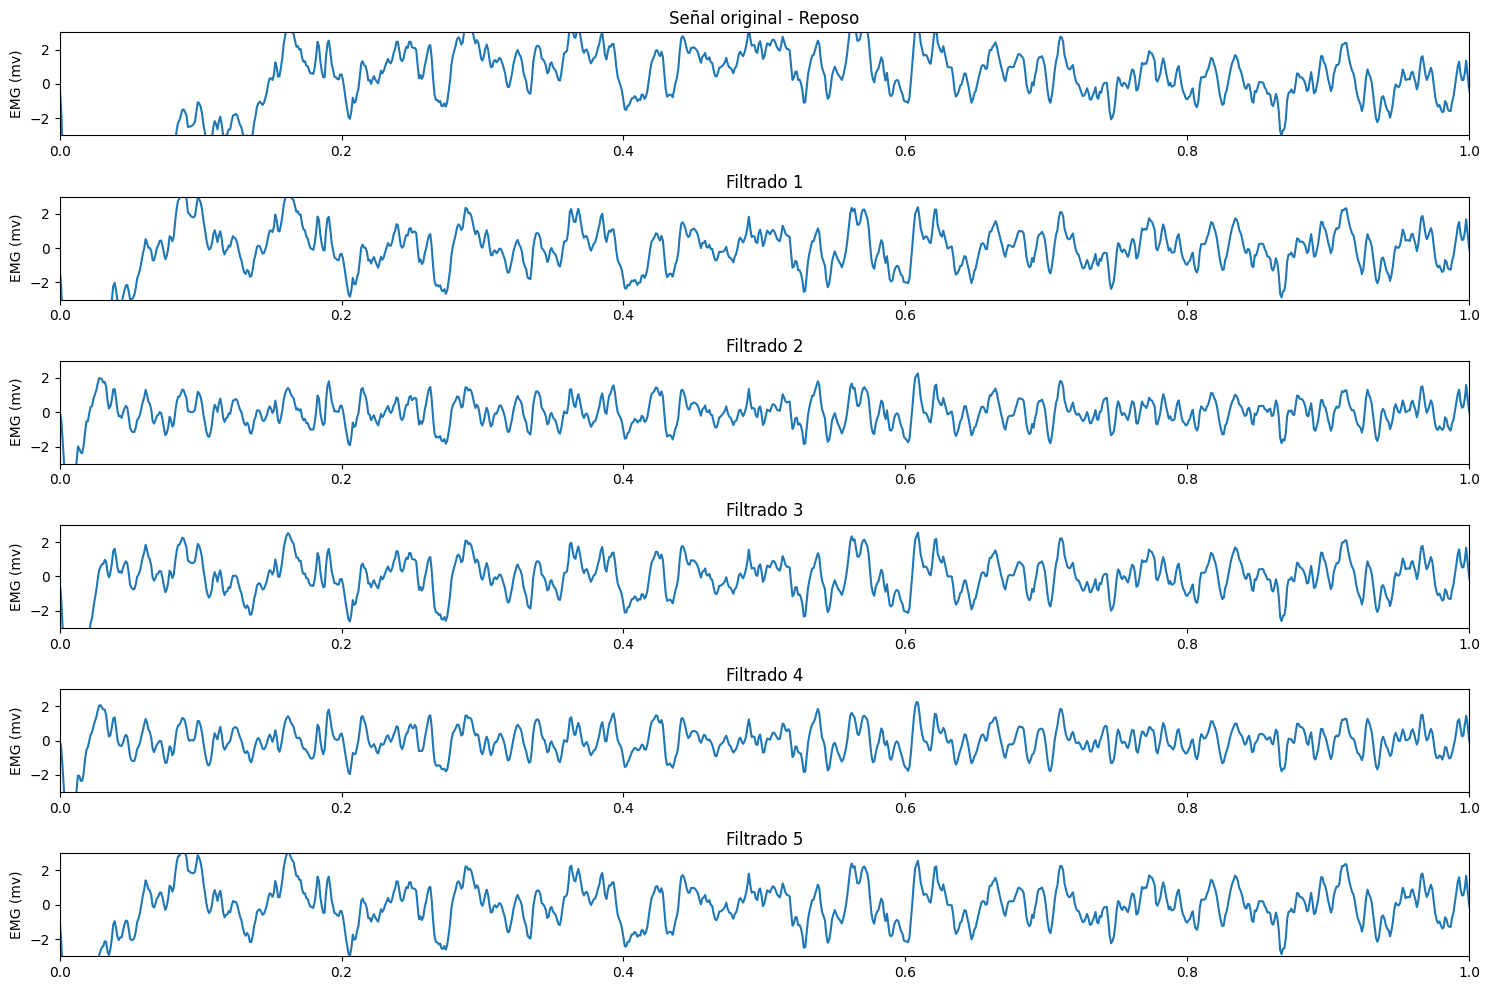

In [7]:
# Función para crear un filtro pasa banda Butterworth
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    if high >= 1.0:
        high = 0.99  # Ajuste para evitar error de frecuencia superior igual a la frecuencia de Nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Función para crear un filtro Notch
def notch_filter(freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist
    b, a = signal.iirnotch(freq, quality_factor)
    return b, a

# Función para filtrar una señal
def apply_filter(data, b, a):
    return signal.filtfilt(b, a, data)

# Aplicar los diferentes filtrados
filters = [
    {'name': 'Filtrado 1', 'lowcut': 5, 'highcut': 500, 'notch': 60},
    {'name': 'Filtrado 2', 'lowcut': 20, 'highcut': 500, 'notch': 50},
    {'name': 'Filtrado 3', 'lowcut': 10, 'highcut': 500, 'notch': None},
    {'name': 'Filtrado 4', 'lowcut': 20, 'highcut': 350, 'notch': 50},
    {'name': 'Filtrado 5', 'lowcut': 6, 'highcut': 500, 'notch': None}
]

filtered_signals = []

for f in filters:
    # Aplicar filtro pasa banda
    b_band, a_band = butter_bandpass(f['lowcut'], f['highcut'], fs)
    filtered_signal = apply_filter(EMG_uV, b_band, a_band)
    
    # Aplicar filtro Notch si es necesario
    if f['notch']:
        b_notch, a_notch = notch_filter(f['notch'], fs)
        filtered_signal = apply_filter(filtered_signal, b_notch, a_notch)
    
    filtered_signals.append({'name': f['name'], 'signal': filtered_signal})

# Plotear las señales filtradas
plt.figure(figsize=(15, 10))
plt.subplot(6, 1, 1)
plt.plot(time, EMG_uV)
plt.ylim(-3, 3)
plt.ylabel('EMG (mv)')
plt.xlim(0, 1)
plt.title('Señal original - Reposo')

for i, f in enumerate(filtered_signals, start=2):
    plt.subplot(6, 1, i)
    plt.plot(time, f['signal'])
    plt.ylim(-3, 3)
    plt.ylabel('EMG (mv)')
    plt.xlim(0, 1)
    plt.title(f['name'])

plt.tight_layout()
plt.show()